In [1]:
from brian2 import *
from brian2tools import *
from utils.equations import nav18_eqs, threshold_str, refractory_str, gNa18_eq
from utils.eq_params import *

%load_ext autoreload
%autoreload 2
prefs.codegen.target = "numpy"

Patch clamp

In [61]:
start_scope()
g18nav = 200*nS
patchclamp_gna18_eq = gNa18_eq + Equations("v : volt (constant)")

nav18_only_group = NeuronGroup(1, patchclamp_gna18_eq,
                               namespace={"gNa18": g18nav}, method="exponential_euler")
nav18_only_group.v = -65 * mV
nav18_only_statemon = StateMonitor(nav18_only_group, ["INa18"], True)
store("patch_clamp_init")


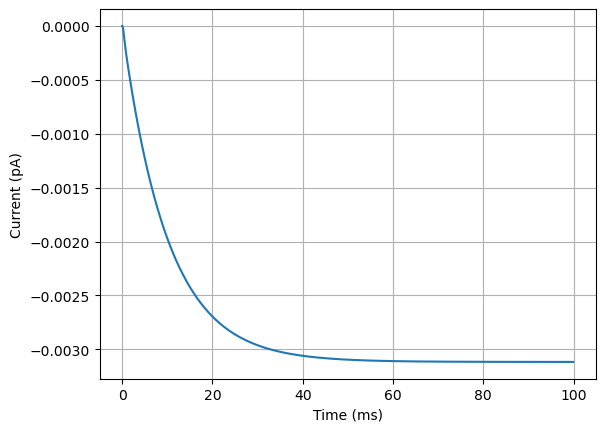

In [30]:
plot(nav18_only_statemon.t / ms, nav18_only_statemon.INa18[0] / pA)
xlabel("Time (ms)")
ylabel("Current (pA)")
grid()

In [72]:
# write a function that iterate over list of voltages and returns the
# list of max currents at the end of simulation.
# simulattion should start after restore("path_clamp_init")
# and end after run(100*ms). for each iteration, group.v should be set to loop variable
def max_currents(voltages):
    max_current_values = []
    for v in voltages:
        restore("patch_clamp_init")
        nav18_only_group.v = v
        run(200*ms)
        max_current_values.append(abs(nav18_only_statemon.INa18[0] / pA).max())
    return max_current_values


def max_conductances(voltages):
    max_g = []
    for v in voltages:
        restore("patch_clamp_init")
        nav18_only_group.v = v
        run(200 * ms)
        max_g.append(abs(nav18_only_statemon.INa18[0]).max() / v)
    return max_g


def plot_max_g(voltages):
    for v in voltages:
        restore("patch_clamp_init")
        nav18_only_group.v = v
        run(200 * ms)
        plot(nav18_only_statemon.t / ms, nav18_only_statemon.INa18[0] / pA)
        grid()
        xlabel("Time (ms)")
        ylabel("Current (pA)")


def ln_G(max_g, g_18nav):
    """
    Returns a list of log(max_g/(g_18nav - max_g)). Where max_g is the element of max_gs
    """
    max_g = abs(array(max_g/nS))*nS
    return log(max_g / (g_18nav - max_g))


def plot_ln_G_vs_voltages(max_g, voltages, g_18nav):
    ln_G_vals = ln_G(max_g, g_18nav)
    plot(voltages / mV, ln_G_vals)
    xlabel("Voltage (mV)")
    ylabel("$ln\\frac{G_{Na}}{G^{max}_{Na}-G_{Na}}$")
    grid()


WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -70. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -60. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -50. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -40. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with t

[1.96447389e-02 1.38938099e-01 2.18819108e+00 7.92324126e+01
 2.15145686e+03 6.98917002e+03] pS
[-199.99998036 -199.99986106 -199.99781181 -199.92076759 -197.84854314
 -193.01082998] nS


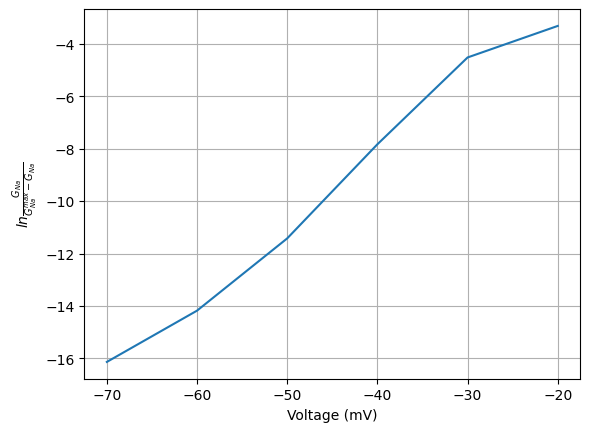

In [73]:
experimental_voltages = arange(-70, -10, 10) * mV
max_gs = max_conductances(experimental_voltages)
plot_ln_G_vs_voltages(max_gs, experimental_voltages, g18nav)